In [1]:
#LSTM
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from IPython.display import HTML,display
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
import seaborn as sns
import re
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

import warnings
warnings.filterwarnings("ignore")

2024-07-25 21:56:02.671143: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 21:56:02.699141: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 21:56:02.839892: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 21:56:02.841651: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 21:56:03.940326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
df = pd.read_csv('/media/yatipa_drive/sep_ana/reduced_dataset_0-end.csv',index_col=0)
product_count = df.groupby('product_name').size().reset_index(name='count').sort_values(by='count', ascending=False)


In [3]:
# ref: https://www.kaggle.com/code/hajaribrahiem/nlp-sentiment-analysis-sephora-reviews
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#removing the stopwords
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')
stop=set(stopwords.words('english'))
#Tokenization of text
tokenizer=ToktokTokenizer()
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [4]:


# Load the reduced dataset
df = pd.read_csv('reduced_dataset.csv')
# df = df[df.product_name == product_count.iloc[0].product_name] ##########
# Shuffling means the data is presented to the model during training in a random order, which prevents it from memorizing the specific sequence and encourages it to learn the general patterns in the data
df = shuffle(df) 
# Preprocess the data
df['review_text'].fillna('', inplace=True)

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-English characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply text cleaning
df['cleaned_review_text'] = df['review_text'].apply(clean_text)
df['cleaned_review_text']=df['cleaned_review_text'].apply(simple_stemmer) ##########
df['cleaned_review_text']=df['cleaned_review_text'].apply(remove_stopwords) ########## remove stop words in English are “the”, “a”, “an”, “so”, “what”.
# Function to detect language and filter out non-English reviews
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Filter out non-English reviews
df = df[df['cleaned_review_text'].apply(is_english)]

# Encode the labels
label_encoder = LabelEncoder()
# 2 1 0 where bad --> good
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# Tokenize the cleaned text data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_review_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review_text'])

# Pad the sequences
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['sentiment'], test_size=0.3, random_state=42)


In [5]:
# def display_review(index_lst):
#      df.reset_index(drop=True)
#      for i in index_lst:
#             display(HTML(f"<h5><b style='color:red'>Review: </b>{df['cleaned_review_text'].iloc[i]}</h5>"))
#             display(HTML(f"<h5><b style='color:white'>sentiment: </b>{ df['sentiment'].iloc[i]}</h5>"))
#           #   label = "negative" if df['sentiment'].iloc[i] ==0 else "positive" 
# index_lst= np.random.randint(1,len(df) ,5)
# display_review(index_lst) 

In [6]:
#Percentage of Positive/Negative after we balance dataset
print("Negative: ", round(df.sentiment.value_counts()[2]/len(df)*100 , 2 ),"%")
print("Soso: ", round(df.sentiment.value_counts()[1]/len(df)*100 , 2 ),"%")
print("Positive: ", round(df.sentiment.value_counts()[0]/len(df)*100, 2 ),"%")

Negative:  33.77 %
Soso:  32.7 %
Positive:  33.53 %


In [7]:
# Load GloVe embeddings
def load_glove_embeddings(filepath, word_index, embedding_dim=300):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Use the 300-dimensional GloVe embeddings
glove_filepath = 'glove.42B.300d.txt'
embedding_dim = 300
embedding_matrix = load_glove_embeddings(glove_filepath, tokenizer.word_index, embedding_dim)

# Build the model with GloVe embeddings
# def build_model_with_glove():
#     model = Sequential([
#         Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
#         Bidirectional(LSTM(128, return_sequences=True)),
#         Dropout(0.7),
#         Bidirectional(LSTM(64, return_sequences=True)),
#         Dropout(0.7),
#         Bidirectional(LSTM(32)),
#         Dropout(0.7),
#         Dense(128, activation='relu'),
#         Dropout(0.5),
#         Dense(64, activation='relu'),
#         Dense(3, activation='softmax')
#     ])
#     model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model.
def build_model_with_glove():
    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
        Bidirectional(LSTM(256, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model_with_glove()

# Hyperparameters
epochs = 25
batch_size = 256

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

# Predict probabilities
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


2024-07-25 21:57:15.146314: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-25 21:57:15.438587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 21:57:15.439561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 21:57:15.440086: I tensorflow/core/com

Epoch 1/25


2024-07-25 21:57:16.121642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 21:57:16.124261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 21:57:16.125123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - ETA: 0s - loss: 1.1072 - accuracy: 0.3213

2024-07-25 21:57:26.904761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 21:57:26.905987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 21:57:26.906493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 13s 898ms/step - loss: 1.1072 - accuracy: 0.3213 - val_loss: 1.0972 - val_accuracy: 0.3512
Epoch 2/25
9/9 [==============================] - 7s 840ms/step - loss: 1.1037 - accuracy: 0.3482 - val_loss: 1.0956 - val_accuracy: 0.3859
Epoch 3/25
9/9 [==============================] - 8s 869ms/step - loss: 1.0991 - accuracy: 0.3463 - val_loss: 1.0919 - val_accuracy: 0.4105
Epoch 4/25
9/9 [==============================] - 8s 871ms/step - loss: 1.0900 - accuracy: 0.3746 - val_loss: 1.0702 - val_accuracy: 0.4150
Epoch 5/25
9/9 [==============================] - 7s 799ms/step - loss: 1.0408 - accuracy: 0.4537 - val_loss: 1.0060 - val_accuracy: 0.4832
Epoch 6/25
9/9 [==============================] - 7s 774ms/step - loss: 0.9817 - accuracy: 0.4983 - val_loss: 1.1653 - val_accuracy: 0.3535
Epoch 7/25
9/9 [==============================] - 7s 841ms/step - loss: 0.9973 - accuracy: 0.4801 - val_loss: 0.9582 - val_accuracy: 0.4810
Epoch 8/25
9/9 [==============

2024-07-25 22:00:24.452777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 22:00:24.453632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 22:00:24.454411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - 3s 56ms/step


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          1183800   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 512)         1140736   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 512)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         656384    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 100, 256)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              1

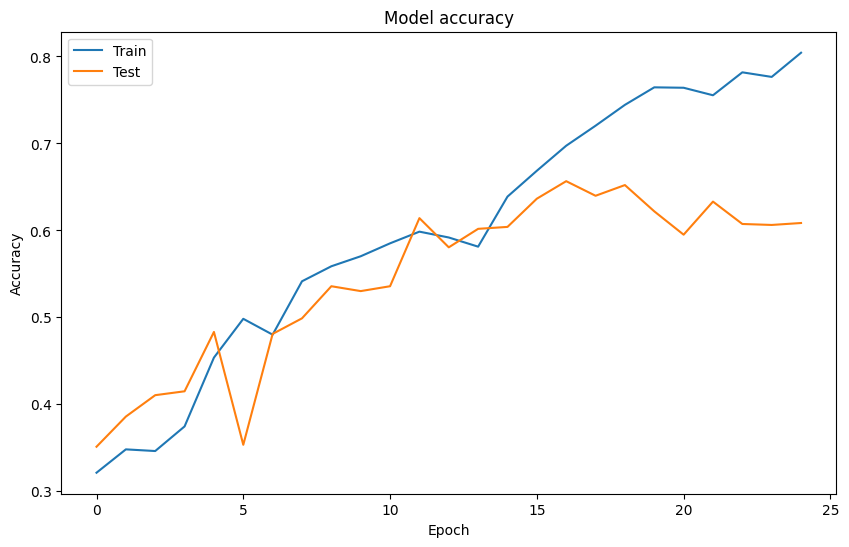

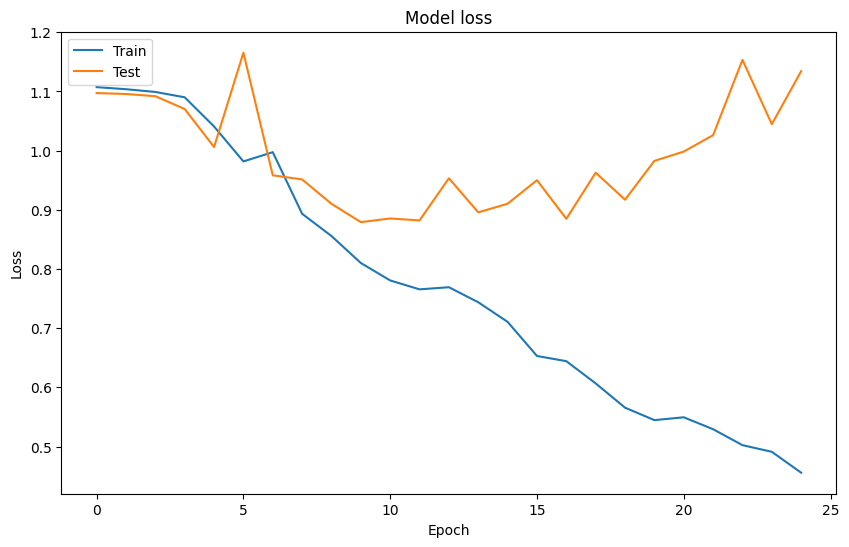

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

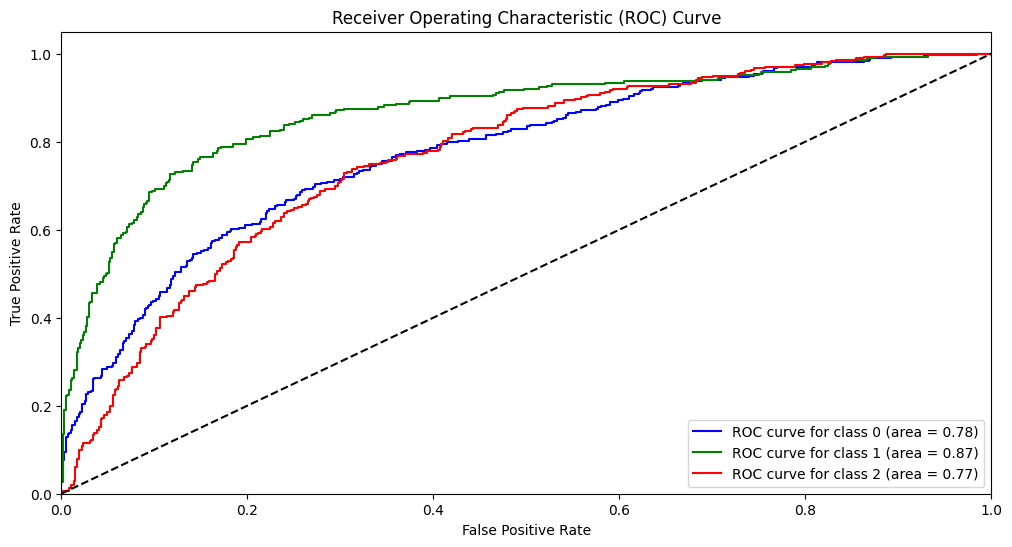

In [10]:

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 6))
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


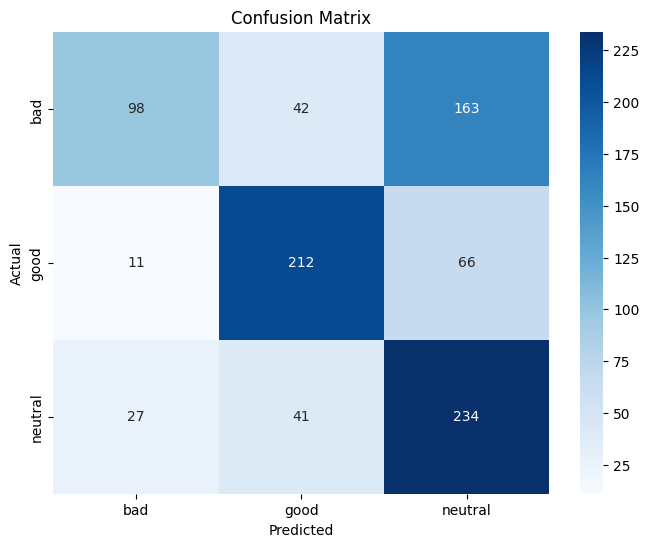

AttributeError: 'LabelEncoder' object has no attribute 'classes'

In [11]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes))